In [1]:
# loading packages
import pandas as pd
import numpy as np
from datetime import date

import os

# plotting packages
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as clrs
import seaborn as sns

# Kmeans algorithm from scikit-learn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering 
from collections import defaultdict

In [2]:
msa_rename = {
    'New York-Newark-Jersey City, NY-NJ-PA (MSA)' : 'New York',
    'Los Angeles-Long Beach-Anaheim, CA (MSA)' : 'Los Angeles',
    'Chicago-Naperville-Elgin, IL-IN-WI (MSA)' : 'Chicago',
    'Dallas-Fort Worth-Arlington, TX (MSA)' : 'Dallas',
    'Houston-The Woodlands-Sugar Land, TX (MSA)' : 'Houston',
    'Washington-Arlington-Alexandria, DC-VA-MD-WV (MSA)' : 'Washington DC',
    'Miami-Fort Lauderdale-West Palm Beach, FL (MSA)' : 'Miami',
    'Philadelphia-Camden-Wilmington, PA-NJ-DE-MD (MSA)' : 'Philadelphia',
    'Atlanta-Sandy Springs-Roswell, GA (MSA)' : 'Atlanta',
    'Phoenix-Mesa-Chandler, AZ (MSA)' : 'Phoenix',
    'Boston-Cambridge-Newton, MA-NH (MSA)' : 'Boston',
    'San Francisco-Oakland-Hayward, CA (MSA)' : 'San Francisco',
    'Riverside-San Bernardino-Ontario, CA (MSA)' : 'Riverside',
    'Detroit-Warren-Dearborn, MI (MSA)' : 'Detroit',
    'Seattle-Tacoma-Bellevue, WA (MSA)' : 'Seattle',
    'Minneapolis-St. Paul-Bloomington, MN-WI (MSA)' : 'Minneapolis',
    'San Diego-Chula Vista-Carlsbad, CA (MSA)' : 'San Diego',
    'Tampa-St. Petersburg-Clearwater, FL (MSA)' : 'Tampa',
    'Denver-Aurora-Lakewood, CO (MSA)' : 'Denver',
    'St. Louis, MO-IL (MSA)' : 'St Louis',
    'Baltimore-Columbia-Towson, MD (MSA)' : 'Baltimore',
    'Charlotte-Concord-Gastonia, NC-SC (MSA)' : 'Charlotte',
    'Orlando-Kissimmee-Sanford, FL (MSA)' : 'Orlando',
    'San Antonio-New Braunfels, TX (MSA)' : 'San Antonio',
    'Portland-Vancouver-Hillsboro, OR-WA (MSA)' : 'Portland',
    'Sacramento-Roseville-Folsom, CA (MSA)' : 'Sacramento',
    'Las Vegas-Henderson-Paradise, NV (MSA)' : 'Las Vegas',
    'Pittsburgh, PA (MSA)' : 'Pittsburgh',
    'Austin-Round Rock, TX (MSA)' : 'Austin',
    'Cincinnati, OH-KY-IN (MSA)' : 'Cincinnati',
    'Kansas City, MO-KS (MSA)' : 'Kansas City',
    'Columbus, OH (MSA)' : 'Columbus',
    'Indianapolis-Carmel-Anderson, IN (MSA)' : 'Indianapolis',
    'Cleveland-Elyria, OH (MSA)' : 'Cleveland',
    'San Jose-Sunnyvale-Santa Clara, CA (MSA)' : 'San Jose',
    'Nashville-Davidson--Murfreesboro, TN (MSA)' : 'Nashville',
    'Virginia Beach-Norfolk-Newport News, VA-NC (MSA)' : 'Virginia Beach',
    'Providence-Warwick, RI-MA (MSA)' : 'Providence',
    'Jacksonville, FL (MSA)' : 'Jacksonville',
    'Milwaukee-Waukesha, WI (MSA)' : 'Milwaukee',
    'Oklahoma City, OK (MSA)' : 'Oklahoma City',
    'Raleigh-Cary, NC (MSA)' : 'Raleigh',
    'Memphis, TN-MS-AR (MSA)' : 'Memphis',
    'Richmond, VA (MSA)' : 'Richmond',
    'New Orleans-Metairie, LA (MSA)' : 'New Orleans',
    'Louisville-Jefferson County, KY-IN (MSA)' : 'Louisville',
    'Salt Lake City, UT (MSA)' : 'Salt Lake City',
    'Hartford-West Hartford-East Hartford, CT (MSA)' : 'Hartford',
    'Buffalo-Cheektowaga-Niagara Falls, NY (MSA)' : 'Buffalo',
    'Birmingham-Hoover, AL (MSA)' : 'Birmingham',
    
    ## MSADs
    'New York-Jersey City-White Plains, NY-NJ (MSAD)' : 'New York',
    'Los Angeles-Long Beach-Glendale, CA (MD)' : 'Los Angeles',
    'San Francisco-San Mateo-Redwood City, CA (MSAD)' : 'San Francisco',
    'Chicago-Naperville-Evanston, IL (MSAD)' : 'Chicago',
    'Dallas-Plano-Irving, TX (MSAD)' : 'Dallas',
    'Washington-Arlington-Alexandria, DC-VA-MD-WV (MSAD)' : 'Washington DC',
    'Miami-Miami Beach-Kendall, FL (MSAD)' : 'Miami',
    'Philadelphia, PA (MSAD)' : 'Philadelphia',
    'Boston, MA (MSAD)' : 'Boston',
    'Detroit-Dearborn-Livonia, MI (MSAD)' : 'Detroit',
    'Seattle-Bellevue-Kent, WA (MSAD)' : 'Seattle'
}

remove_msas = [
    'Hartford-West Hartford-East Hartford, CT (MSA)',
    'Boston, MA (MSAD)',
    'Providence-Warwick, RI-MA (MSA)',
    'Los Angeles-Long Beach-Glendale, CA (MD)',
    'Los Angeles-Long Beach-Anaheim, CA (MSA)'
]

raw_df = pd.read_csv('fred_data_part_3_data.csv'
                     ,parse_dates=['date']
                     ,index_col=['date']
                    ).drop(columns='Unnamed: 0')
raw_df = raw_df.rename(columns={" value ": "value"})
raw_df['value'] = raw_df['value'].str.replace(",","").str.strip()
raw_df['value'] = raw_df['value'].str.replace("(","-").str.replace(")","")
raw_df['value'] = pd.to_numeric(raw_df['value'], errors='coerce')
raw_df = raw_df[~raw_df.msa.isin(remove_msas)]


shortnames = {i:i[:i.find("-")][:i.find(",")] for i in set(raw_df['msa'])}

def create_series_df(series, start_date, start_year,cluster_year, actual_mean=False):
    today = date.today().strftime("%Y-%m-%d")
    df = raw_df[raw_df['series'] == series]
    df = df.loc[df.index >= start_date]
    df = df.loc[df.index <= today]
    df['prev_value'] = df.groupby(['msa'])['value'].shift(1).astype('float')
    df[f'mean_value_{series}'] = df['value']
    df[f'perc_change_from_prev_{series}'] = (df['value'] / df['prev_value']) - 1
    df[f'perc_change_from_prev_{series}'].sort_index(ascending=False).rolling(4).mean().sort_index(ascending=True)
    df['year'] = pd.DatetimeIndex(df.index).year
    df = df.replace({"msa": msa_rename})

    if actual_mean:
        agg_func = {
            f'mean_value_{series}': ['mean'],
        }
    else:
        agg_func = {
            f'perc_change_from_prev_{series}': ['describe'],
        }

    agg_df = df.groupby(['msa','year']).agg(agg_func).round(4).unstack()
    if actual_mean:
        metric_df = agg_df.iloc[:, agg_df.columns.get_level_values(1)=='mean']
        k = metric_df.iloc[:,metric_df.columns.get_level_values(2)>=start_year].copy()
        k = metric_df.iloc[:,metric_df.columns.get_level_values(2)<=cluster_year].copy()
    else:
        metric_df = agg_df.iloc[:, agg_df.columns.get_level_values(2)=='mean']
        k = metric_df.iloc[:,metric_df.columns.get_level_values(3)>=start_year].copy()
        k = metric_df.iloc[:,metric_df.columns.get_level_values(3)<=cluster_year].copy()

    return k

<ipython-input-2-f8e97e7f0fe2>:81: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  raw_df['value'] = raw_df['value'].str.replace("(","-").str.replace(")","")


In [3]:
def get_clusters(start_date, start_year, cluster_year, k):
    home_prices = create_series_df('All-Transactions House Price Index', start_date, start_year, cluster_year) #2000-2019
    real_gdp = create_series_df('Total Real Gross Domestic Product', start_date, start_year, cluster_year) #2000-2019
    employees = create_series_df('All Employees: Total Nonfarm', start_date, start_year, cluster_year)#2000-2019
    unemployment_growth = create_series_df('Unemployment Rate', start_date, start_year, cluster_year)#2000-2019
    unemployment_rate = create_series_df('Unemployment Rate', start_date, start_year, cluster_year, actual_mean=True)#2000-2019
    housing_inventory = create_series_df('Housing Inventory: Active Listing Count in', start_date, start_year, cluster_year) #2016-2020
    resident_population = create_series_df('Resident Population in', start_date, start_year, cluster_year) 

    # The dictionary holds a tuple of (df,[years to be included])
    chosen_features = {
        'home_prices' : (home_prices, [cluster_year]),
        'unemployment_growth' : (unemployment_growth, [cluster_year]),
        'housing_inventory' : (housing_inventory, [cluster_year]),
        'resident_population' : (resident_population, [cluster_year]),
        'real_gdp' :(real_gdp, [cluster_year]),
        'employees' : (employees,[cluster_year]),
    }

    for i in chosen_features:
        if list(chosen_features.keys()).index(i) == 0:
            j = chosen_features[i][0].iloc[:,np.in1d(chosen_features[i][0].columns.get_level_values(3), chosen_features[i][1])]
            j.columns = j.columns.get_level_values(0)
            k_df = j.copy()
        else:
            j = chosen_features[i][0].iloc[:,np.in1d(chosen_features[i][0].columns.get_level_values(3), chosen_features[i][1])]
            j.columns = j.columns.get_level_values(0)
            k_df = pd.merge(k_df, j.copy(), on=["msa"], how='left')
    # run_k_means(years_describe,years_describe.columns,3,normalize=False)
    k_df = k_df.fillna(0)
    df = k_df.copy()
    #fill missing values
    df = df.fillna(df.median())
    labels_df = df.reset_index()
    features = df.columns
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(df)
    y = kmeans.labels_
    norm = clrs.Normalize(vmin=0.,vmax=y.max() + 0.8)
    cmap = cm.viridis
    centers = kmeans.cluster_centers_
    labels_df['cluster'] = y
    labels_df['msa'] = labels_df['msa'] + ' - ' + labels_df['cluster'].astype('str')
    clusters_df = labels_df.sort_values(by = 'cluster').set_index('msa')
    clusters_feats_ranked = clusters_df.groupby('cluster').mean().rank(ascending=False)

    return clusters_feats_ranked, clusters_df

def add_return_rankings(clusters_df,clusters_feats_ranked ,cluster_year,rank):
    PerformanceSummary = pd.DataFrame()
    prices_df = pd.read_csv('Prices_City.csv')
    Clusters = []
    Returns = []
    Cities = {}
    for i in range(0,k):
        c = 'Cluster' + str(i)
        cluster = clusters_df[clusters_df['cluster'] == i]
        c_return, c_names = get_returns(cluster, prices_df, cluster_year)
        Clusters.append(i)
        Returns.append(c_return)
        Cities[i] = c_names
        
    #Create a data frame of the clusters and their returns, ranked
    PerformanceSummary = pd.DataFrame(list(zip(Clusters, Returns)), columns = ['Clusters', 'Cumulative_Return'])
    PerformanceSummary = PerformanceSummary.sort_values(by='Cumulative_Return', ascending = False).set_index('Clusters')
    PerformanceSummary['Return Rank'] = PerformanceSummary.rank(ascending=False)
    Cluster =  PerformanceSummary.index[rank-1]
    City_list = Cities[Cluster]
    clusters_summary = clusters_feats_ranked.join(PerformanceSummary)
    
    return clusters_summary, City_list

    
def get_returns(cluster, prices_df, cluster_year):
    """"Gets cumulative return of a cluster"""
    # Get a list of cities in the cluster
    cities = list(cluster.index)
    city_names = []
    for c in cities:
        city = c.split('-')
        city_names.append(city[0].strip())

    #Get a list of cities in the price data
    names = list(prices_df.columns)
    full_names = []
    for c in names:
        city = c.split(',')
        full_names.append(c)
    full_names.remove('Year')
    full_names.remove('Quarter')

    #get a list of cities in the cluster and in the price data
    cluster_names = []
    price_names = []
    for c in city_names:
        for d in full_names:
            name = d.split(',')
            city = name[0].strip()
            if c == city and c not in cluster_names:
                cluster_names.append(c)
                price_names.append(d)

    price_columns = price_names.append('Quarter')
    price_columns = price_names.append('Year')
    df = prices_df[price_names]

    # Define starting point
    df = df[df['Year'] > cluster_year - 1]
    df = df.groupby(by = ['Year']).mean()

    #get cluster mean and city
    avg_price = df.mean(axis = 1)
    avg_return = avg_price.pct_change()

    #get cumulative return
    cum_returns = (1+avg_return).cumprod()
    return_todate = cum_returns.iloc[-1]
    
    return return_todate, cluster_names


def get_historical_avgs(k, rank):
    Cluster = pd.DataFrame()
    dd = defaultdict(lambda:dd)
    Cities = dd

    cluster_year = list(range(2000,2016))

    for i in cluster_year:
        start_year = i - 5
        start_date = str(start_year) + '-01-01'
        
        #get ranked clusters each year
        clusters_feats_ranked, clusters_df = get_clusters(start_date, start_year, i, k)
        #get the returns of the clusters
        clusters_summary, Best_Cities = add_return_rankings(clusters_df,clusters_feats_ranked ,i, 1)
        clusters_summary =clusters_summary.sort_values(by = 'Return Rank')
        best = clusters_summary[clusters_summary['Return Rank'] ==rank]
        best_cluster = best.reset_index().set_index('Return Rank')
        best_rankings = best_cluster.loc[rank]
        Cluster[i] = best_rankings
        Cities[i] = Best_Cities


    Cluster = Cluster.rename(index = {
            'cluster': 'Cluster', 
            'perc_change_from_prev_All-Transactions House Price Index' : 'House Price',
           'perc_change_from_prev_Unemployment Rate': 'Unemployment Rate',
           'perc_change_from_prev_Resident Population in': 'Resident Population',
            'perc_change_from_prev_Total Real Gross Domestic Product':'GDP',
           'perc_change_from_prev_All Employees: Total Nonfarm' : 'Employees'})

    Cluster = Cluster.drop('Cluster')
    Cluster_avg = Cluster.mean(axis=1)
    return Cluster, Cluster_avg

## Ranking Clusters over two decades and calculating the average rank of features

In [4]:
Averages = pd.DataFrame()
dd = defaultdict(lambda:dd)
Clusters = dd
k = 4
rank = list(range(1,k+1))

for i in rank:
    cluster, cluster_avg = get_historical_avgs(k,i)
    Averages[i] = cluster_avg
    Clusters[i] = cluster

Averages.sort_values(by=1)

,1,2,3,4
Cumulative_Return,1.234374,1.203765,1.184717,1.143536
House Price,1.750000,2.437500,2.937500,2.875000
Employees,1.812500,2.625000,3.125000,2.437500
Resident Population,2.343750,2.312500,3.125000,2.218750
Unemployment Rate,2.875000,2.625000,2.125000,2.375000


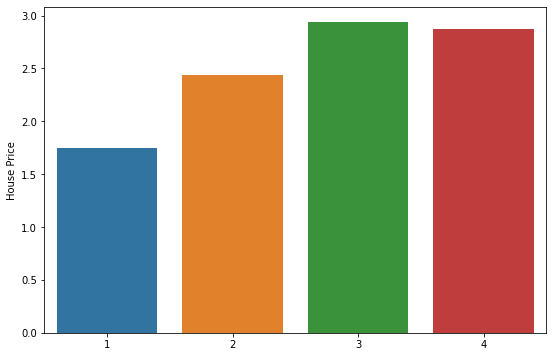

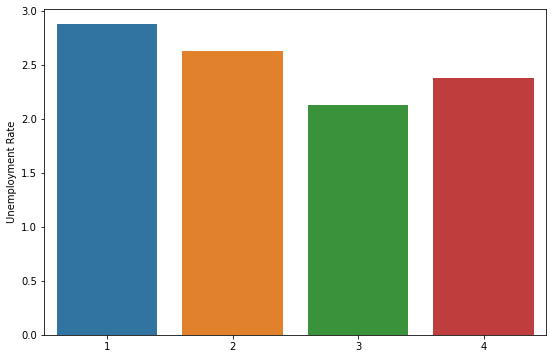

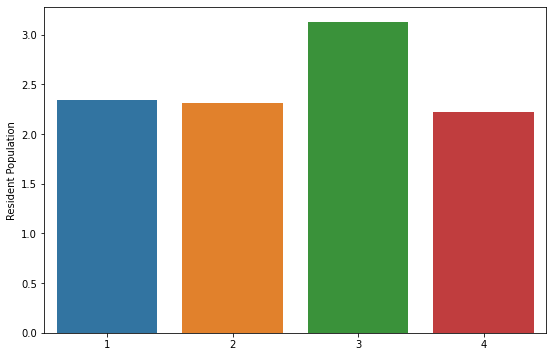

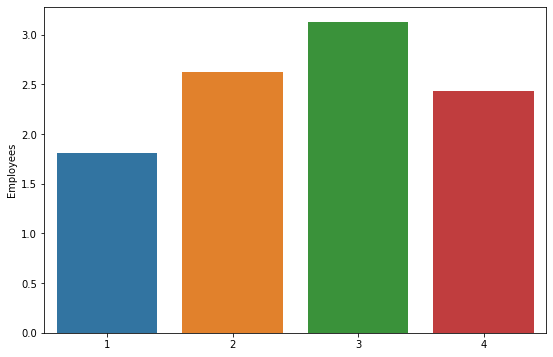

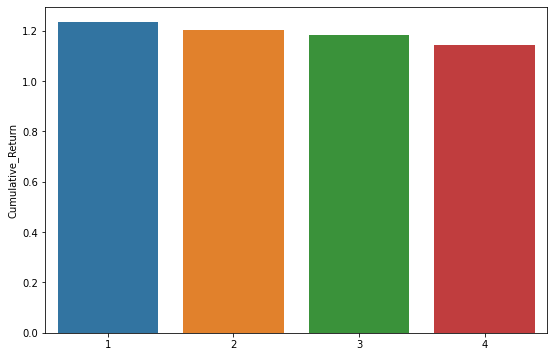

In [34]:
Averages = Averages.T
names = list(Averages.columns)
for i in names:
    plt.figure(figsize=[9,6])
    plt.tight_layout() 
    sns.barplot(x = Averages.index, y = i, data = Averages)
    plt.show()

## Cluster on 2020 data and filter based on top 3 feature rankings attained above
1. House Price Index
2. Employees
3. Population Growth 

In [5]:
start_date = '2015-01-01'
start_year = 2015
cluster_year = 2020
k =4
rank = 1

clusters_feats_ranked, clusters_df = get_clusters(start_date, start_year, cluster_year, k)

In [6]:
houses = clusters_df.sort_values(by='perc_change_from_prev_All-Transactions House Price Index', ascending=False).head(10)
houses_emp = houses.sort_values('perc_change_from_prev_All Employees: Total Nonfarm', ascending=False).head(7)
predicted_hotspots = houses_emp.sort_values('perc_change_from_prev_Resident Population in', ascending=False).head(5)
predicted_hotspots

,perc_change_from_prev_All-Transactions House Price Index,perc_change_from_prev_Unemployment Rate,perc_change_from_prev_Housing Inventory: Active Listing Count in,perc_change_from_prev_Resident Population in,perc_change_from_prev_All Employees: Total Nonfarm,cluster
msa,,,,,,
Austin - 0,0.0206,0.1568,-0.0621,0.0302,-0.0018,0
Phoenix - 2,0.0249,0.1243,-0.0475,0.0214,-0.0027,2
Charlotte - 0,0.0186,0.1748,-0.0541,0.0167,-0.0021,0
Tampa - 2,0.0201,0.0875,-0.0492,0.0137,-0.0022,2
Indianapolis - 0,0.0189,0.1832,-0.0481,0.0085,-0.0023,0
